# Backyard Bird Science with Alan

## Overview

- I set up a Wyze camera in my backyard to record activity at my bird feeder
- I've been capturing images of birds since 2024/02/12
- I'm using Facebook's Detection Transformer (DETR) to detect birds
- To date, I've captured more than 100K images of birds at the feeder
- I've evaluated several pre-trained bird classification algorithms (spoiler alert: they all suck)
- The end goal is to catalog how many birds of each type visit my feeder per day
- Stretch goal: birds perform light housework while I sing along (like a Disney Princess)

![princess](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQqomriIqM11dKHENHuuOvEd1FQPnvY5Iz0qAXXiBThNCI5AHVOl7jZBpfQGSLsmHMVpiI&usqp=CAU)

## Camera Setup

- Product
  - [Wyze cam version 3](https://www.wyze.com/products/wyze-cam)

<div><img src=https://www.wyze.com/cdn/shop/products/v3.png width="500"></div>


- RTSP
  - Stands for [real time streaming protocol](https://en.wikipedia.org/wiki/Real-Time_Streaming_Protocol)
  - Can capture the video stream from a URL using tools such as [VLC](https://www.videolan.org) or [open cv](https://opencv.org)
  - Wyze does not support RTSP out of the box, but provides [optional firmware](https://support.wyze.com/hc/en-us/articles/360026245231-Wyze-Cam-RTSP)
  
![wyze rtsp](./misc/wyze_rtsp.png)

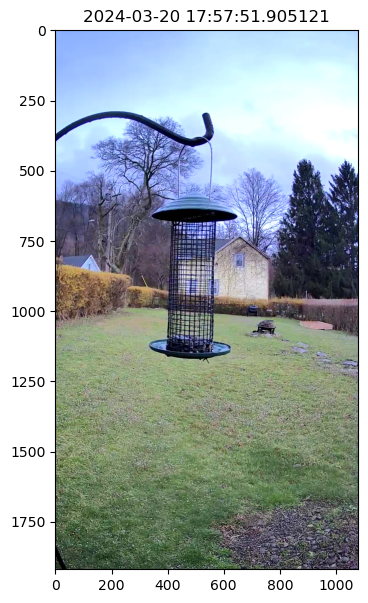

In [1]:
# once the firmware is installed and you've setup rtsp in the Wyze app, you can use opencv to access the video stream
import cv2
import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import time
%matplotlib inline

# rtsp username and password are define within the Wyze app
# store password in environment variables (in my bashrc file)
# never hard code passwords and store on a public site such as github!
username = os.environ['RTSP_USERNAME']
password = os.environ['RTSP_PASSWORD']

# url on local network
url = '192.168.1.176'

# rtsp connection string
rtsp = f'rtsp://{username}:{password}@{url}/live'

# video capture
cap = cv2.VideoCapture(rtsp)

# begin an endless loop (always a good idea)
while True:
    # set framerate to frames per second
    time.sleep(0.5)

    # get current timestamp
    now = datetime.datetime.now()

    # read frame as a numpy array, along with boolean flag that indicates successful read
    valid, frame = cap.read()

    # check for valid frame
    if valid:
        # write image to file
        cv2.imwrite(f'images/{now.strftime("%Y%m%d_%H%M%S%f")}.jpg', frame)

        # display image
        clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(7, 7))

        # i turned my camera sideways, so need to tranpose
        ax.imshow(np.transpose(frame[::-1, :, ::-1], (1, 0, 2)))
        ax.set_title(now)
        plt.show()
    else:
        # in case of frame read failure, attempt to reconnect 
        cap.release()
        cap = cv2.VideoCapture(rtsp)

    # break for the sake of this demo
    break
cap.release()

In [2]:
# images are captured as unsigned 8 bit integers
frame.dtype

dtype('uint8')

In [3]:
# each image is 1080 pixels wide by 1920 pixels high (plus three color channels: red, green, and blue)
frame.shape

(1080, 1920, 3)

In [4]:
# as unsigned 8 bit integers, each color occupies the range 0 to 255
frame.min(), frame.max()

(0, 255)

In [5]:
# using unsigned 8 bit integers with 3 color channels (red, green, and blue), you can represent nearly 17M colors!
256**3

16777216

In [6]:
# I collect 2 images per second
# Each image is about 1 MB, so more than 100GB per day!

## Bird Detection

- To detect birds, I use [Facebook's Detection Transformer (DETR)](https://github.com/facebookresearch/detr).   
- I obtain the pretrained model from [TorchHub](https://pytorch.org/hub/)
- The DETR was trained on the [COCO Dataset](https://cocodataset.org/), which contains 92 classes (including birds!)
- In addition to object type, the COCO dataset is also labelled with bounding boxes

In [7]:
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

# use the GPU to speed up model scoring
device = torch.device(0)

# download the pre-trained DETR model from torch hub
model = torch.hub.load('facebookresearch/detr:main', 'detr_resnet50', pretrained=True).to(device)

# define a pytorch dataset for image data
class ImageSet(Dataset):
    # initialize dataset with datetime string
    def __init__(self, dt = '20240305_095918614389'):
        super().__init__()
        # extract all the image files with the date string
        self.img_files = sorted(glob.glob(f'images/{dt}*.jpg'))
        
        # create a transform object to preprocess the image 
        self.transform =  T.Compose([
            T.ToTensor(),  # convert from PIL Image to pytorch tensor (also converts from range 0-255 to 0-1)
            T.Normalize(0.5, 0.5)  # normalize from the range 0 to 1 to the range -1 to 1
        ])

    def __len__(self):
        # pytorch datasets require a length method, so return the number of files
        return len(self.img_files)

    def __getitem__(self, i):
        # pytorch datasets require a get item method, with a numeric index
        img_file = self.img_files[i]  # get the image filename
        img = Image.open(img_file)  # load as PIL image
        Z = self.transform(img)  # apply tranform from init function
        return Z, img_file  # return image tensor and filename

# create instance of dataset
imset = ImageSet()

# the data loader organizes the output of the dataset into batches
# however, due to memory constraints, I can only load one image at a time
loader = DataLoader(imset, batch_size=1, shuffle=False)

# run the model on a single test image and inspect the results
Z, img_file = next(iter(loader))
results = model(Z.to(device))

Using cache found in /home/alan/.cache/torch/hub/facebookresearch_detr_main
/home/alan/miniconda3/envs/mytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alan/miniconda3/envs/mytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# the model output consists of prediction logits and bounding boxes
results.keys()

dict_keys(['pred_logits', 'pred_boxes'])

In [9]:
# prediction logits have 3 dimensions
# 0: batch (in this case 1)
# 1: number of objects detected (fixed at shape 100, but contains N/A)
# 2: number of categories (in this case 92)
results['pred_logits'].shape

torch.Size([1, 100, 92])

In [10]:
# bounding boxes also have 3 dimensions
# 0: batch
# 1: number of objects detected
# 2: bounding box coordinates (normalized to 0-1)
results['pred_boxes'].shape

torch.Size([1, 100, 4])

In [11]:
# to obtain actual probabilities, apply the softmax function
probs = results['pred_logits'].softmax(-1)

# to obtain the actual category, apply the argmax function
class_idx = probs.argmax(-1)

In [12]:
class_idx.shape

torch.Size([1, 100])

In [13]:
# category labels come from DETR's colab notebook
# https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_attention.ipynb
class_labels = [    
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
len(class_labels)

91

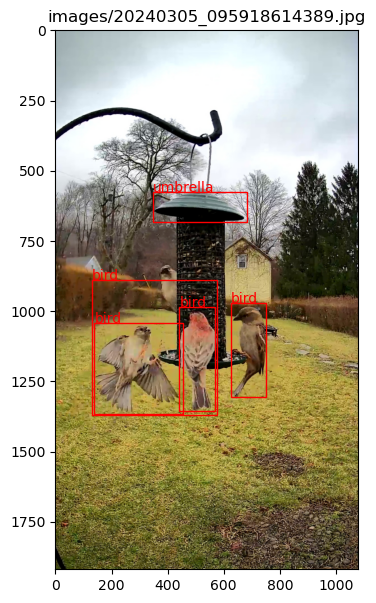

In [14]:
# show image with detections
from matplotlib.patches import Rectangle

# transform from tensor back to image
to_pil = T.Compose([T.Lambda(lambda x: (x+1)/2), T.ToPILImage()])
img = to_pil(Z[0])

fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(img)
ax.set_title(img_file[0])

# iterate through detected objects
for i, idx in enumerate(class_idx[0]):
    # null objects are assigned the label 91, which is out of bounds for the class labels above
    if idx >= 91:
        continue

    # extract bounding box (note: coordinates are between 0 and 1)
    # (must move to CPU, detach from gradient calculation, and convert to numpy array)
    x, y, dx, dy = results['pred_boxes'][0, i].cpu().detach().numpy()
    # x, y are the center point, dx, dy are the width and height
    x0 = x - dx/2
    y0 = 1 - y - dy/2

    # plot bounding box and label
    rect = Rectangle([x0, y0], dx, dy, facecolor='None', edgecolor='r', transform=ax.transAxes)
    ax.add_patch(rect)
    ax.text(x0, y0+dy, class_labels[idx.item()], transform=ax.transAxes, color='r', fontsize=10)

plt.show()

## DETR Evaluation

In that absence of a manually labelled validation set, I don't have quantitative performance metrics for the DETR model on my data. However, I have observed some qualitative examples of type I and type II errors.

### Type I Errors
- Squirels
- Cats
- Rocks

Text(0.5, 1.0, 'rocks')

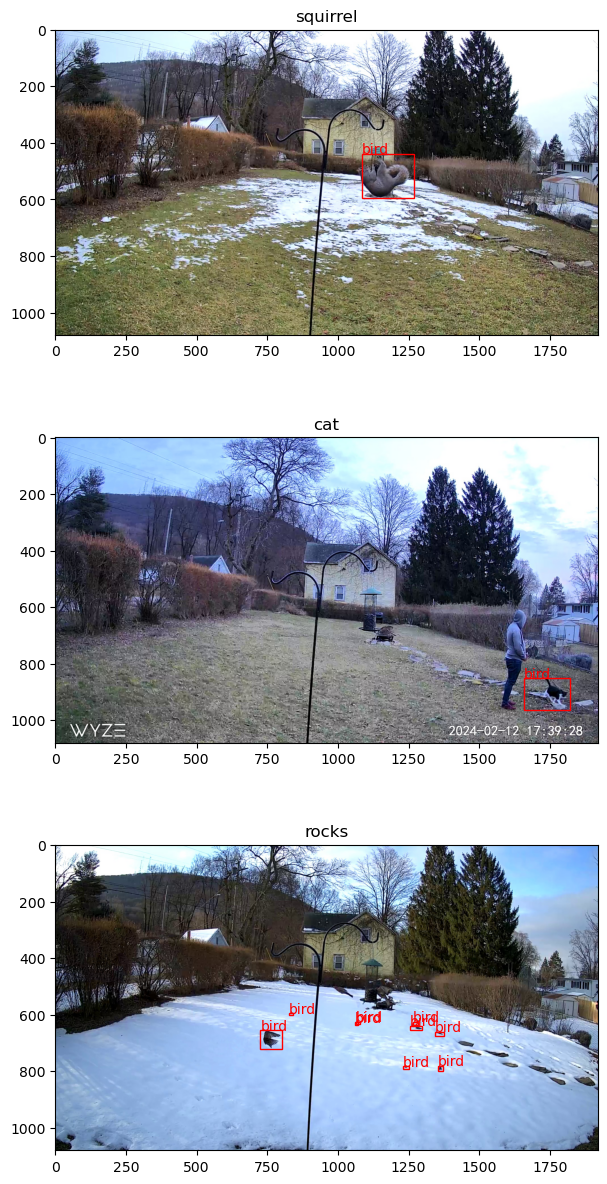

In [22]:
from utils import plot_frame

fig, ax = plt.subplots(3, figsize=(7, 15))

# squirrel
ax[0] = plot_frame('images/20240223_163418086447.jpg', ax=ax[0])
ax[0].set_title('squirrel')

# cat
ax[1] = plot_frame('images/20240212_174116452401.jpg', ax=ax[1])
ax[1].set_title('cat')

# rocks
ax[2] = plot_frame('images/20240222_081209928608.jpg', ax=ax[2])
ax[2].set_title('rocks')

### Type II Errors
- Multiple birds in one shot
- The same bird not detected in consecutive frames

Okay, so the algorithm isn't perfect, but I'm not going to hand label 173K frames every day, and I'm rapidly running out of storage space. Each day I retain frames that occur within one minute of a bird detection, and even that won't be sustainable for much longer.

## Bird Classification

- Now that I've detected the birds, I'd like to categorize them
- I've tried 3 pre-trained models (one from pytorch, and two from huggingface)
- I've defined a validation set to evaluate the performance of these models
- The results are underwhelming

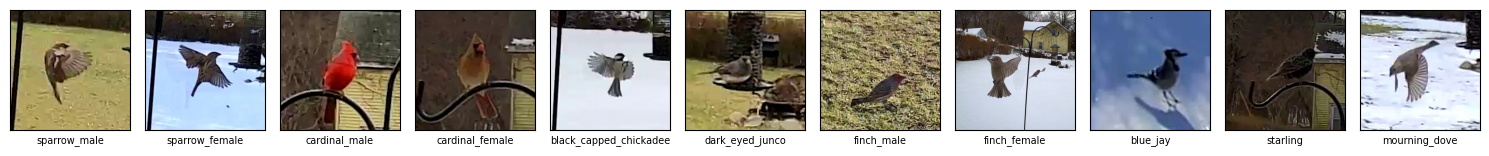

In [16]:
# display the validation set
import numpy as np
import pandas as pd

# this validation set was created using manual labeling by an amateur bird watcher (i.e. me)
validation = pd.read_csv('results/validation.txt', delimiter=',')
resized_images = []

# create figure and axes
fig, ax = plt.subplots(1, 11, figsize=(15, 3))

# iterate through rows and columns of figure
for i in range(11):
    # get bird data
    row = validation.iloc[i]
    img = Image.open(row['filename'])

    # image width and height
    W, H = img.width, img.height

    # max of width or height to make a square
    w = int(max(W*row['dx'], H*row['dy']))

    # extract bird from full image
    x0 = int(W * row['x']) - w
    y0 = int(H * row['y']) - w
    x1 = int(W * row['x']) + w
    y1 = int(H * row['y']) + w
    # account for edges
    if x1 >= W:
        buff = x1 - W
        x0 -= buff
    if y1 >= H:
        buff = y1 - H
        y0 -= buff
    img_array = np.array(img)[y0:y1, x0:x1]
    resized_images.append(img_array)
    
    # display
    ax[i].imshow(img_array)
    ax[i].set_xlabel(row['category'], rotation=0, size=7)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

validation['resized_image'] = resized_images
plt.tight_layout()
plt.show()

Using cache found in /home/alan/.cache/torch/hub/nicolalandro_ntsnet-cub200_master
/home/alan/miniconda3/envs/mytorch/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


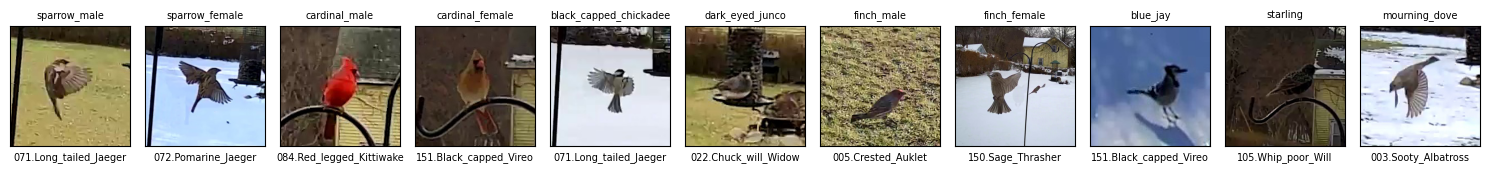

In [17]:
# https://pytorch.org/hub/nicolalandro_ntsnet-cub200_ntsnet/
# CUB200 2011 dataset
# https://www.vision.caltech.edu/datasets/cub_200_2011/

transform_test = T.Compose([
    T.ToTensor(),
    T.Resize((448, 448), Image.BILINEAR),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

model = torch.hub.load('nicolalandro/ntsnet-cub200', 'ntsnet', pretrained=True, **{'topN': 6, 'device':'cpu', 'num_classes': 200})
model.eval()

# create figure and axes
fig, ax = plt.subplots(1, 11, figsize=(15, 3))

for i, row in validation.iterrows():
    img = row['resized_image']
    scaled_img = transform_test(img)
    torch_images = scaled_img.unsqueeze(0)
    
    with torch.no_grad():
        top_n_coordinates, concat_out, raw_logits, concat_logits, part_logits, top_n_index, top_n_prob = model(torch_images)
    
        _, predict = torch.max(concat_logits, 1)
        pred_id = predict.item()

    # plot results
    ax[i].imshow(img)
    ax[i].set_title(row['category'], size=7)
    ax[i].set_xlabel(model.bird_classes[pred_id], size=7)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show()

# possible reason for failure
# - image resultion
# - model lacks location context

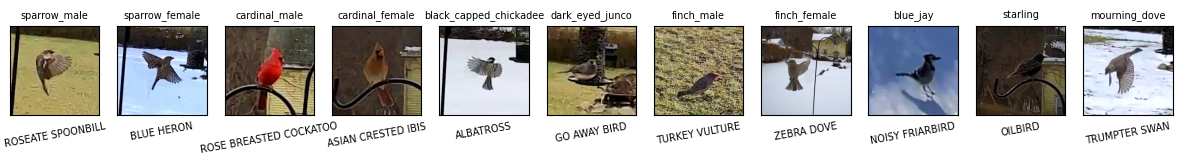

In [18]:
# https://huggingface.co/dennisjooo/Birds-Classifier-EfficientNetB2
# https://www.kaggle.com/datasets/gpiosenka/100-bird-species
# 224x224x3

from transformers import pipeline

# Loading the model and preprocessor using Pipeline
pipe = pipeline("image-classification", model="dennisjooo/Birds-Classifier-EfficientNetB2")

# create figure and axes
fig, ax = plt.subplots(1, 11, figsize=(15, 3))

for i, row in validation.iterrows():
    img = Image.fromarray(row['resized_image'])
    
    # Running the inference
    result = pipe(img)[0]

    # plot results
    ax[i].imshow(img)
    ax[i].set_title(row['category'], size=7)
    ax[i].set_xlabel(result['label'], size=7, rotation=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

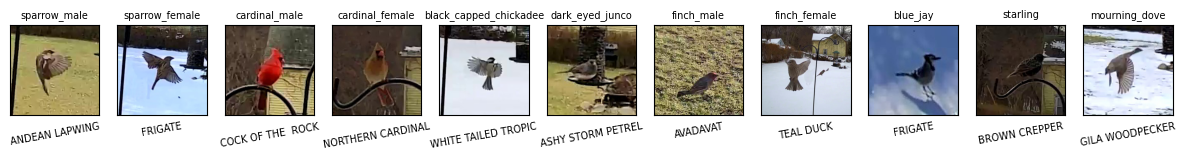

In [19]:
pipe = pipeline("image-classification", model="chriamue/bird-species-classifier")

# create figure and axes
fig, ax = plt.subplots(1, 11, figsize=(15, 3))

for i, row in validation.iterrows():
    img = Image.fromarray(row['resized_image'])
    
    # Running the inference
    result = pipe(img)[0]

    # plot results
    ax[i].imshow(img)
    ax[i].set_title(row['category'], size=7)
    ax[i].set_xlabel(result['label'], size=7, rotation=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

### Datasets
- https://www.vision.caltech.edu/datasets/cub_200_2011/
- https://www.kaggle.com/datasets/akash2907/bird-species-classification
- https://www.kaggle.com/datasets/gpiosenka/100-bird-species

# Insights
- Types of birds observed to date
  - House sparrow
  - House finch
  - Cardinal
  - Black capped chickadee
  - Dark eyed junco
  - Starling
  - Mourning dove
  - Robin
  - Crow
- Time of day variation

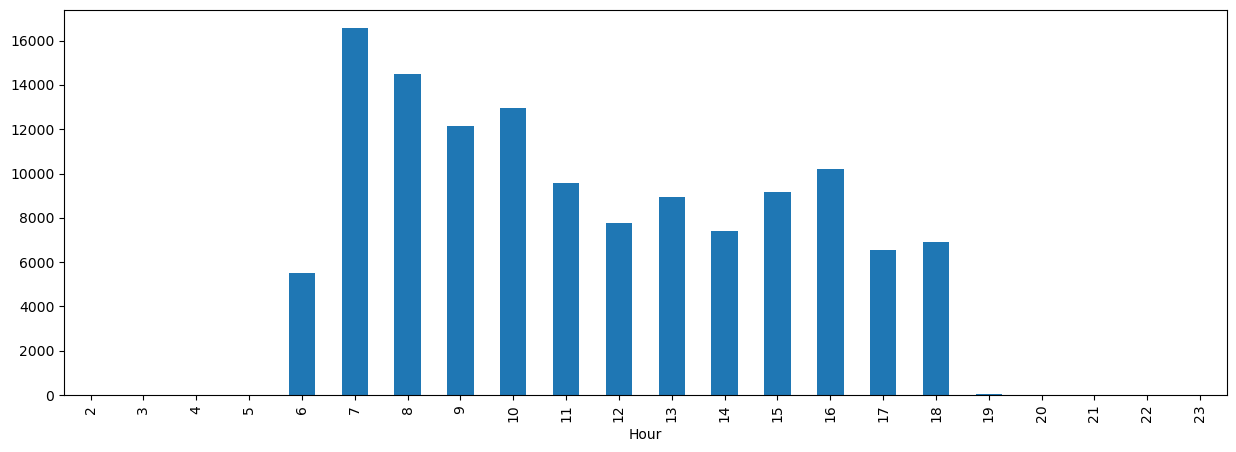

In [23]:
import sqlite3

# i created a sqlite database to store birds
con = sqlite3.connect('data/birds.db')
birds = pd.read_sql('SELECT * FROM birds', con=con)
birds['tstamp'] = pd.to_datetime(birds['filename'], format='images/%Y%m%d_%H%M%S%f.jpg')
hourly = birds.tstamp.dt.hour.value_counts().sort_index()

# plot histogram of birds per hour of the day
fig, ax = plt.subplots(figsize=(15, 5))
hourly.plot(kind='bar', ax=ax)
ax.set_xlabel('Hour')
plt.show()

- The best time of day to see birds is 7 am!

# Next Steps
- Incorporate temporal information
  - I hypothesize that including the previous frame would improve both detection and classification, but non of the models I looked at include frame sequences
- Reporting to Cornell eBird
- Super resolution model
- Semi supervised approach (cluster model output)

# Other applications
- Astronomy
  - On a clear night, the camera is also really handy for mapping the movement of stars and planets across the sky

![astronomy](./misc/stars_20240214.mp4)

- Time lapses
  - In 2020, I worked on a 3 month time lapse to capture the leaves changing color
  - Having a stationary camera will make this much easier
![autumn](https://github.com/leggitta/Autumn/blob/master/autumn.gif?raw=true)